In [ ]:
!cat /proc/cpuinfo
!cat /proc/meminfo
!nvidia-smi

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
addres

In [ ]:
!pip install transformers sentencepiece


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.0 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", li

In [ ]:
import csv
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from pathlib import Path
import json



In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR-large")
model = AutoModel.from_pretrained("cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR-large").cuda(0)

embed target concepts

In [ ]:

concept_names, concept_cuis = [], []
with open("drive/MyDrive/medical-lay/input/german_umls_names_and_cuis.csv", newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in reader:
      assert len(row)== 2
      concept_cuis.append(row[0])
      concept_names.append(row[1].strip())
concept_names = np.array(concept_names)
concept_cuis = np.array(concept_cuis)

88 3 11.513554349259373


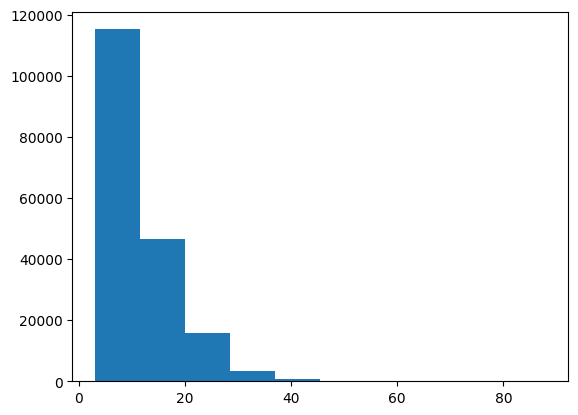

In [ ]:
concept_token_lengths = [len(tokenizer.encode(c)) for c in concept_names]
print(max(concept_token_lengths), min(concept_token_lengths), np.mean(concept_token_lengths))
plt.hist(concept_token_lengths)
plt.show()

In [ ]:
with open("drive/MyDrive/medical-lay/concept_token_lens.json", "w") as fp:
  json.dump(concept_token_lengths, fp)

In [ ]:

cls_index_file = Path("drive/MyDrive/medical-lay/embeddings/SAPBERT_XMLR_large_umls_search_index_cls_token")
mean_all_index_file = Path("drive/MyDrive/medical-lay/embeddings/SAPBERT_XMLR_large_umls_search_index_mean_token")
mean_no_cls_index_file = Path("drive/MyDrive/medical-lay/embeddings/SAPBERT_XMLR_large_umls_search_index_mean_no_cls_token")

bs = 64
MAX_LENGTH = 50

cls_reps = []
mean_reps = []
mean_no_cls_reps = []
file_idx = 0
batch_idx = np.arange(0, len(concept_names), bs)
for i in tqdm(batch_idx):
    toks = tokenizer.batch_encode_plus(concept_names.tolist()[i:i+bs],
                                        padding="max_length",
                                        max_length=MAX_LENGTH,
                                        truncation=True,
                                        return_tensors="pt")
    toks_cuda = {}
    for k,v in toks.items():
        toks_cuda[k] = v.cuda(0)
    output = model(**toks_cuda)

    output = (output['last_hidden_state'].cpu().permute(2,0,1) * toks.attention_mask).permute(1,2,0)
    cls_rep = output[:,0,:].cpu().detach().numpy()
    mean_rep = output.mean(axis=1).cpu().detach().numpy()
    mean_no_cls_rep = output[:,1:,:].mean(axis=1).cpu().detach().numpy()
    del output

    cls_reps.append(cls_rep)
    mean_reps.append(mean_rep)
    mean_no_cls_reps.append(mean_no_cls_rep)

    if (i% (bs*750) == 0  and i != 0) or i == batch_idx[-1]:
      cls_reps = np.concatenate(cls_reps, axis=0)
      mean_reps = np.concatenate(mean_reps, axis=0)
      mean_no_cls_reps = np.concatenate(mean_no_cls_reps, axis=0)

      np.save(str(cls_index_file) + f"_{file_idx}.npy", cls_reps)
      np.save(str(mean_all_index_file) + f"_{file_idx}.npy", mean_reps)
      np.save(str(mean_no_cls_index_file) + f"_{file_idx}.npy", mean_no_cls_reps)
      file_idx += 1
      cls_reps = []
      mean_reps = []
      mean_no_cls_reps = []

100%|██████████| 2844/2844 [12:36<00:00,  3.76it/s]


embed mentions
1. mention
2. mention within sentence

In [ ]:

with open("drive/MyDrive/medical-lay/input/TLC_UMLS.json", "r") as f:
    data = json.load(f)
    X = [entry["mention"] for entry in data]
    X_sent = [entry["mention_sentence"].strip() for entry in data]
    X_sent_mention_offsets = [entry["mention_sentence_spans"] for entry in data]
    Y = [entry["cui"] for entry in data]

In [ ]:
len(X)

6228

20 3 5.8956326268465


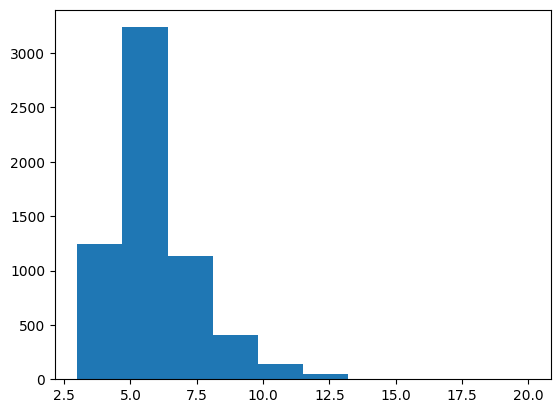

In [ ]:
concept_token_lengths = [len(tokenizer.encode(c)) for c in X]
print(max(concept_token_lengths), min(concept_token_lengths), np.mean(concept_token_lengths))
plt.hist(concept_token_lengths)
plt.show()

In [ ]:
with open("drive/MyDrive/medical-lay/mention_token_lens.json", "w") as fp:
  json.dump(concept_token_lengths, fp)

In [ ]:
mention_embedding = []

MAX_LENGTH = 18
batch_size = 128
for i in tqdm(np.arange(0, len(X), batch_size)):
  toks = tokenizer.batch_encode_plus(X[i:i+batch_size],
                                       padding="max_length",
                                       max_length=MAX_LENGTH,
                                       truncation=True,
                                       return_tensors="pt")
  toks_cuda = {}
  for k,v in toks.items():
      toks_cuda[k] = v.cuda(0)
  output = model(**toks_cuda)
  #output = (output['last_hidden_state'].cpu().permute(2,0,1) * toks.attention_mask).permute(1,2,0)
  output = output[0]
  mention_embedding.append(output.cpu().detach().numpy())
  del output

mention_embedding_file = Path("drive/MyDrive/medical-lay/embeddings/SAPBERT_XMLR_large_mention_embedding.npy")
np.save(mention_embedding_file, np.concatenate(mention_embedding))




100%|██████████| 49/49 [00:06<00:00,  7.57it/s]


2. mention within sentence
first sentence

20 3 5.8956326268465


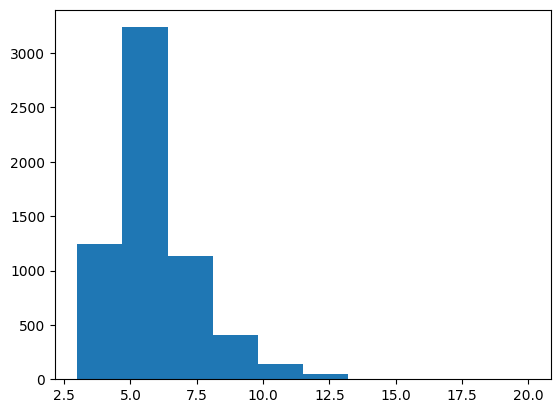

In [ ]:
concept_token_lengths = [len(tokenizer.encode(c)) for c in X]
print(max(concept_token_lengths), min(concept_token_lengths), np.mean(concept_token_lengths))
plt.hist(concept_token_lengths)
plt.show()

In [ ]:
max_length = 150
all_reps = np.zeros(shape=(len(X_sent), max_length, 1024))
batch_size = 2
for i in tqdm(np.arange(0, len(X_sent), batch_size)):
  toks = tokenizer.batch_encode_plus(X_sent[i:i+batch_size],
                                       padding="max_length",
                                       max_length=max_length,
                                       truncation=True,
                                       return_tensors="pt")
  toks_cuda = {}
  for k,v in toks.items():
      toks_cuda[k] = v.cuda(0)
  output = model(**toks_cuda)
  output = (output['last_hidden_state'].cpu().permute(2,0,1) * toks.attention_mask).permute(1,2,0)
  all_reps[i:i+batch_size] = output.cpu().detach().numpy()

100%|██████████| 3114/3114 [01:37<00:00, 32.01it/s]


In [ ]:
index_file = Path("drive/MyDrive/medical-lay/embeddings/SAPBERT_XMLR_mention_with_sentence_embeddings.npy")
np.save(index_file, all_reps)

then translate mention offsets

In [ ]:
# get mention offsets as token indices

all_mention_token_indices = []
for x, (mention_start, mention_end) in zip(X_sent, X_sent_mention_offsets):
  tokens = tokenizer.encode_plus(x,
                                        padding="max_length",
                                        max_length=max_length,
                                        truncation=True,
                                        return_tensors="pt")
  mention_token_indices = []
  found_mention_span = False
  for token_index in range(1,(tokens["input_ids"] != 1).sum() - 1):
    char_span = tokens.token_to_chars(batch_or_token_index=token_index)
    if char_span.start >= mention_start or (char_span.start < mention_start and char_span.end >= mention_start):
      found_mention_span = True
    if found_mention_span:
      mention_token_indices.append(token_index)
    if char_span.end == mention_end:
      found_mention_span = False
      break
  all_mention_token_indices.append(mention_token_indices)

In [ ]:
index_file = Path("drive/MyDrive/medical-lay/embeddings/SAPBERT_XMLR_mention_with_sentence_offsets.npy")
np.save(index_file, all_mention_token_indices)

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
1

1